# Analysis of Orbits in Fourier Space
By: Ari Silburt

In [14]:
import rebound
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

First, let's simulate the outer solar system with inflated masses, which is known to go unstable on short timescales (e.g. Chambers, 1999).

In [66]:
def problem(mass_fac,output_N,tmax):
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.dt = 0.03*2*np.pi
    sim.usleep = 1
    
    #add bodies
    m_jupiter = 9.543e-4
    a_jupiter = 5.2
    sim.add(m=1.)
    sim.add(a=a_jupiter,m=m_jupiter*mass_fac,e=0.01,inc=1e-4,f=np.random.random()*np.pi*2)
    sim.add(a=9.5,m=2.857e-4*mass_fac,e=0.005,inc=1e-3,f=np.random.random()*np.pi*2)
    sim.add(a=19.2,m=4.365e-5*mass_fac,e=0.01,inc=-2e-4,f=np.random.random()*np.pi*2)
    sim.add(a=30.1,m=5e-5*mass_fac,e=0.002,inc=-1e-3,f=np.random.random()*np.pi*2)
    sim.move_to_com()
    E0 = sim.calculate_energy()
    
    sim.exit_min_distance = a_jupiter*(m_jupiter/3.)**(1./3.)
    
    #integrate and output
    output_name = "Fourier/outerSS_t"+str(tmax)+"_massfac"+str(mass_fac)+".csv"
    times = np.linspace(0,tmax*2*np.pi,output_N)
    print 'starting simulation for '+output_name
    with open(output_name, 'w') as f:
        try:
            for t in times:
                sim.integrate(t)
                f.write(str(sim.t/(2*np.pi)))
                outs = []
                for p in sim.particles[1:]:
                    outs = outs + [p.a, p.P, p.e, p.pomega, p.inc, p.Omega, p.f]
                for out in outs:
                    f.write(',{0}'.format(out))
                f.write('\n')
            print 'Simulation '+output_name+' complete. Final energy error is:', abs((E0 - sim.calculate_energy())/E0)
        except rebound.Encounter as error:
            print "Close encounter, simulation "+output_name+" stopping."
            f.write(str(sim.t/(2*np.pi))) 
            outs = []
            for p in sim.particles[1:]:
                outs = outs + [p.a, p.P, p.e, p.pomega, p.inc, p.Omega, p.f]
            for out in outs:
                f.write(',{0}'.format(out))
            f.write('\n')

Setup the basic parameters of the system

In [74]:
n_runs = 20
max_mass_fac = 50

n_outputs = 10000  #number of outputted data points
tmax = 1e6         #simulation time
mass_fac = np.round(np.logspace(0,np.log10(max_mass_fac),n_runs),2)       #inflated mass factor of planets
params = zip(mass_fac,np.ones(n_runs)*n_outputs,np.ones(n_runs)*tmax)

**Warning!** Executing the code below will take a long time!

In [75]:
#Run the problem
import multiprocessing as mp
def execute(pars):
    problem(pars[0],pars[1],pars[2])

if __name__== '__main__':
    pool = mp.Pool(processes=n_runs)
    pool.map(execute, params)
    pool.close()
    pool.join()

Close encounter, simulation Fourier/outerSS_massfac50.0.csv stopping.
Simulation Fourier/outerSS_massfac18.8030154654.csv complete. Final energy error is: 1.17330374477e-09
Simulation Fourier/outerSS_massfac1.0.csv complete. Final energy error is: 4.70840426087e-10
Simulation Fourier/outerSS_massfac7.07106781187.csv complete. Final energy error is: 1.06664684749e-08
Simulation Fourier/outerSS_massfac2.65914794847.csv complete. Final energy error is: 4.0095156871e-09


# Functions
Here are the functions we need to create to do a Fourier analysis

In [8]:
#extra variables that we might want to plot
def get_var(data,i,var):
    if var == 'z':
        e = data["e"+i].values
        pomega = data["pomega"+i].values
        return e*np.exp(pomega*1j)
    if var == "h":
        e = data["e"+i].values
        pomega = data["pomega"+i].values
        return e*np.cos(pomega)
    if var == "k":
        e = data["e"+i].values
        pomega = data["pomega"+i].values
        return e*np.sin(pomega)
    else:
        return data[var+i].values

In [16]:
#1-D frequency map
import scipy.signal as signal
def fourier(data,var,tmax,N_outputs,output_name):        
    N_freq = 200
    t=data["Time"].values
    window = np.hanning(N_outputs)
    logPmin = np.log10(tmax/N_outputs)
    logPmax = np.log10(1e5)
    Period = np.logspace(logPmin,logPmax,N_freq)
    #freq = np.asarray([2*np.pi/P for P in Period])
    freq = np.fft.fftfreq(N_outputs, tmax/N_outputs)#*2*np.pi
    plt.figure(figsize=(12,8))
    names = ['Jupiter','Saturn','Uranus','Neptune']
    for i,num in enumerate(['1', '2', '3', '4']):
        y = get_var(data,num,var)
        #power = signal.lombscargle(t,y*window,freq)
        power = np.fft.fft(y)/N_outputs
        plt.subplot(2, 1, 1)
        plt.plot(2*np.pi/freq,power,label=names[i])
        #plt.plot(Period, np.sqrt(4*power/N_outputs), label=names[i])
        plt.subplot(2, 1, 2)
        plt.plot(t,y,label=num)

    plt.subplots_adjust(hspace=0.4)
    plt.subplot(2, 1, 1)
    plt.ylabel("power of: "+var)
    plt.legend(loc="lower right")
    plt.xlabel('frequencies')
    plt.xscale('log')
    plt.subplot(2, 1, 2)
    plt.ylabel(var)
    plt.xlabel('time')
    plt.savefig(output_name.split(".csv")[0]+"_fft-"+var+".png")

# Analyze
Let's analyze our data now

In [17]:
#If just wanting to batch analyze .csv files
output_name = 'Fourier/*.csv'
var = "z"      #choices are h,k, or any of the orbital elements (e.g. a,P,e,pomega,etc.)

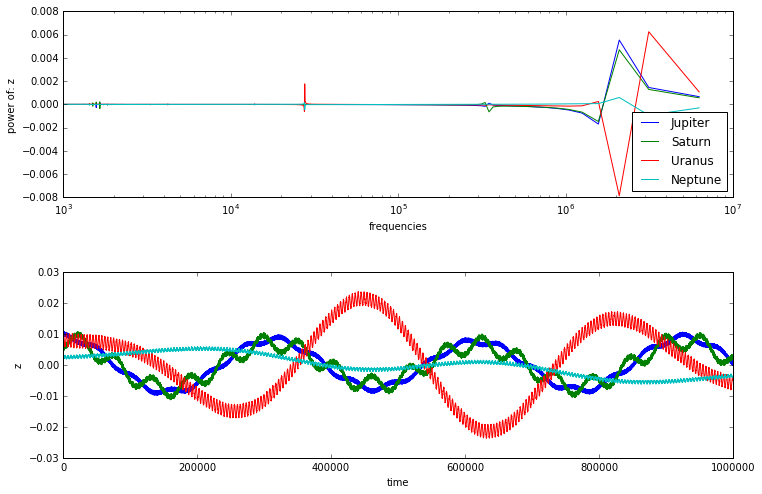

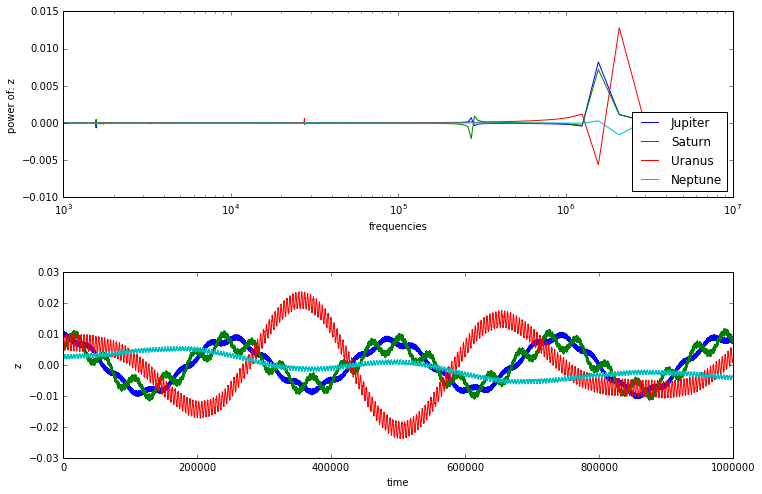

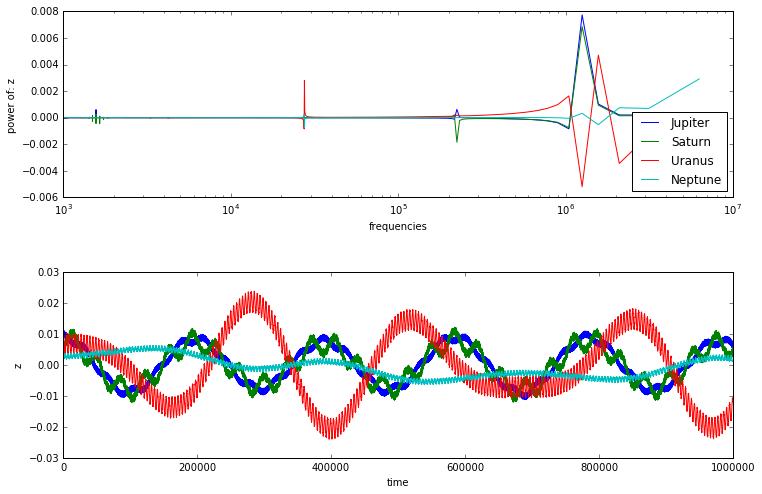

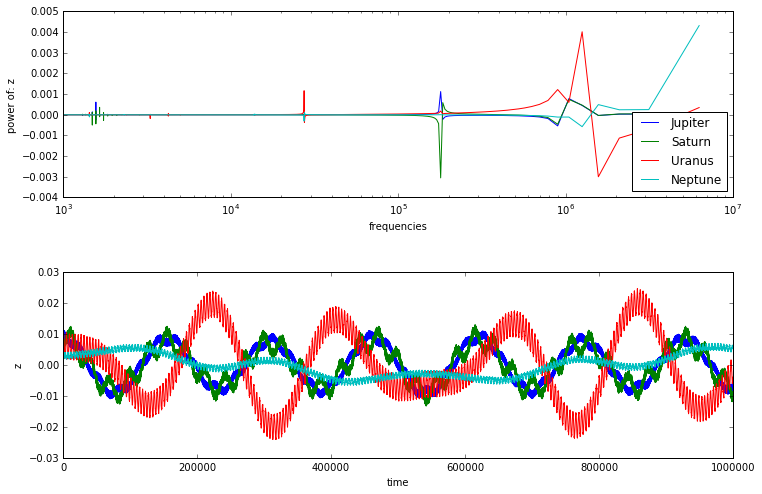

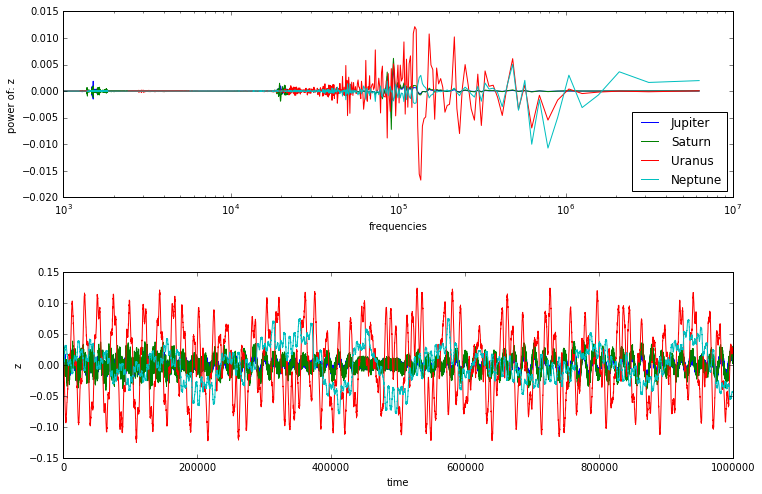

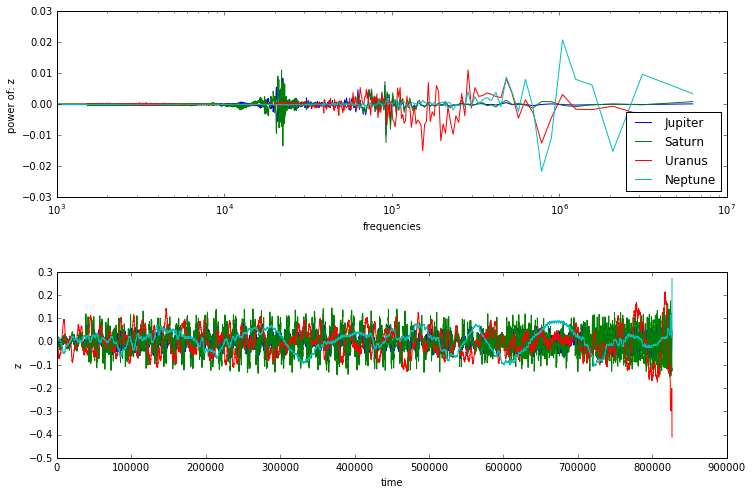

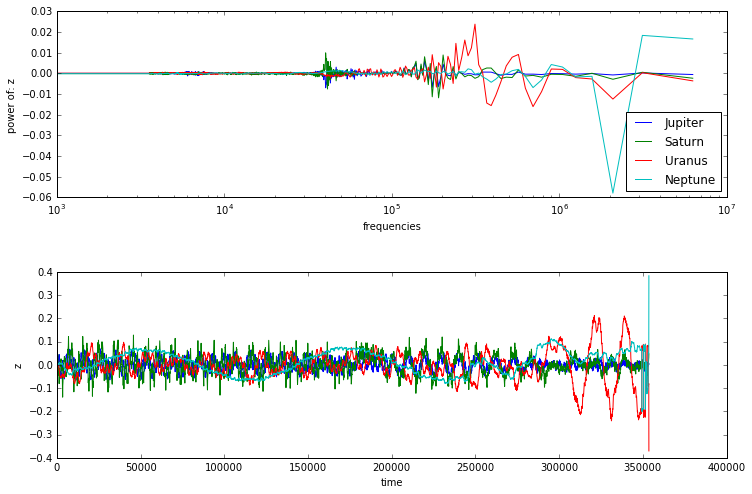

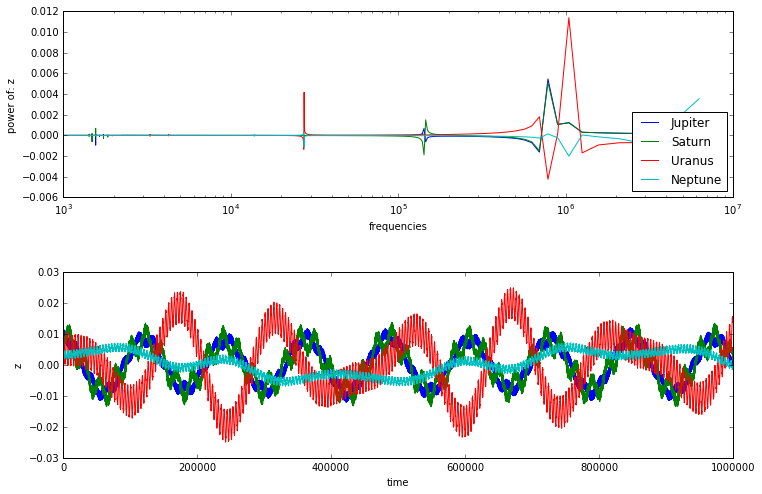

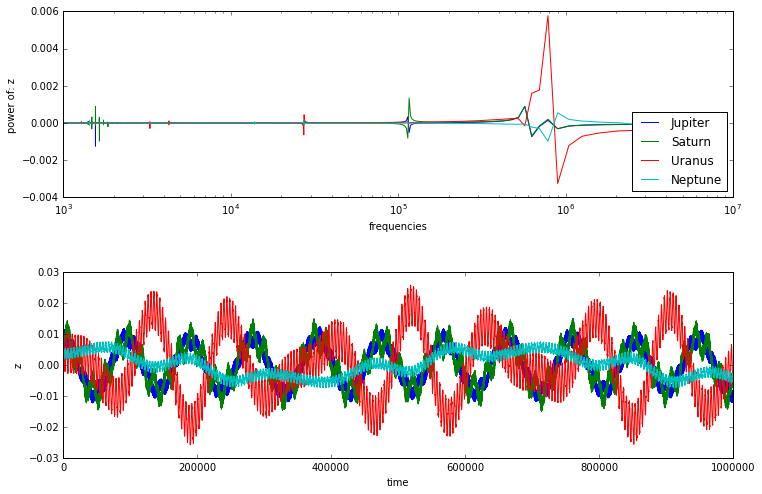

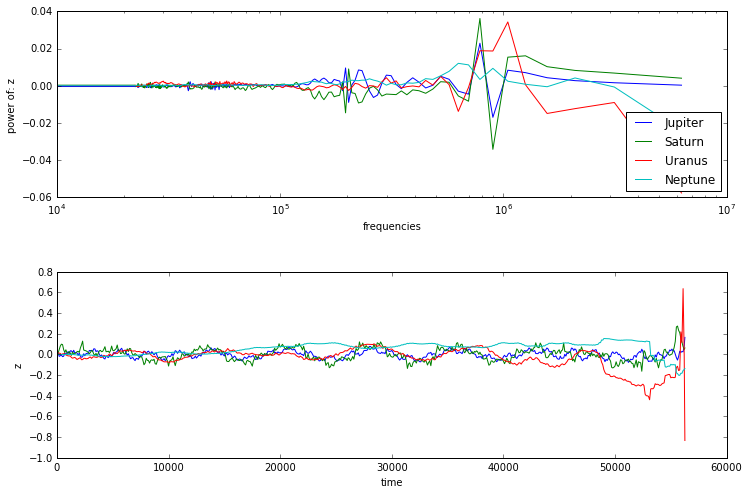

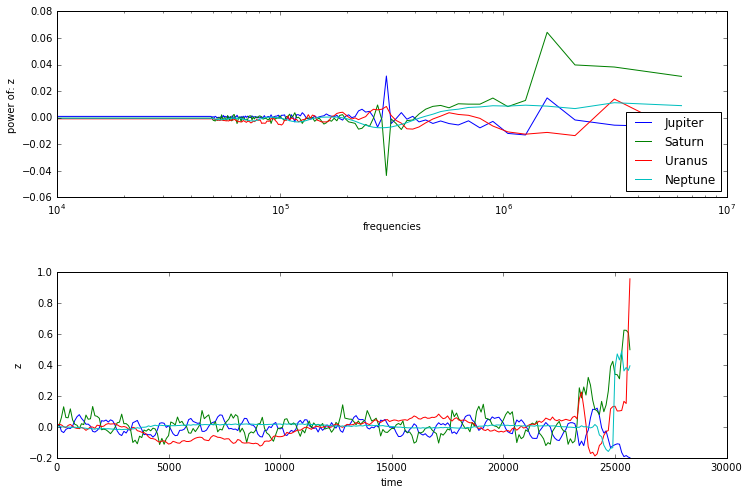

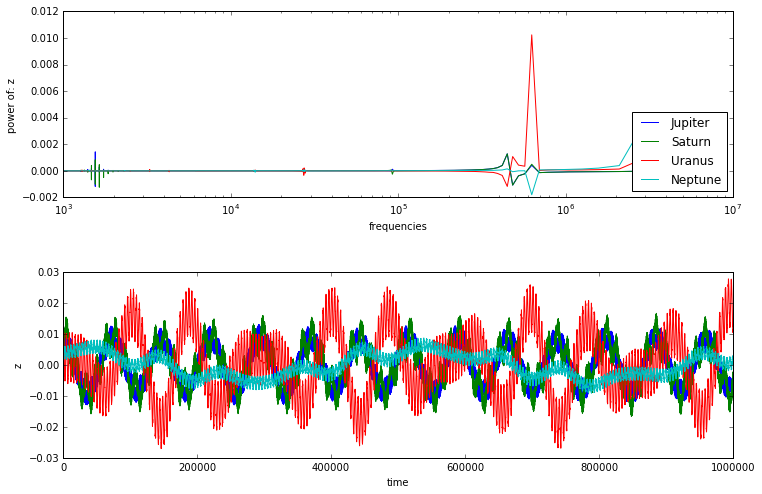

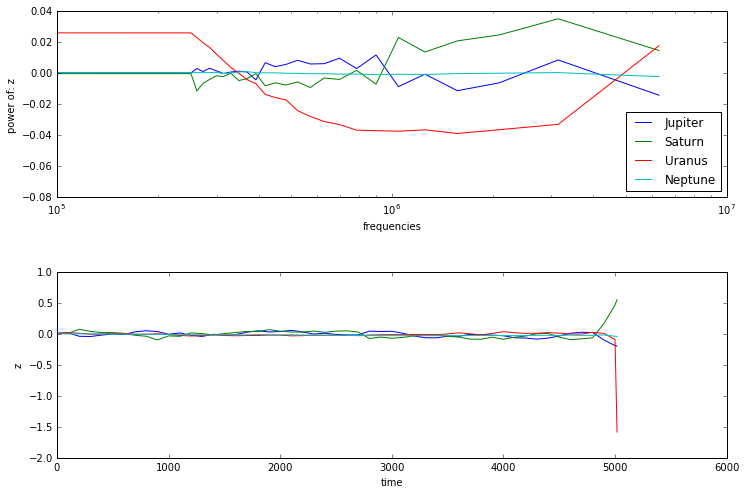

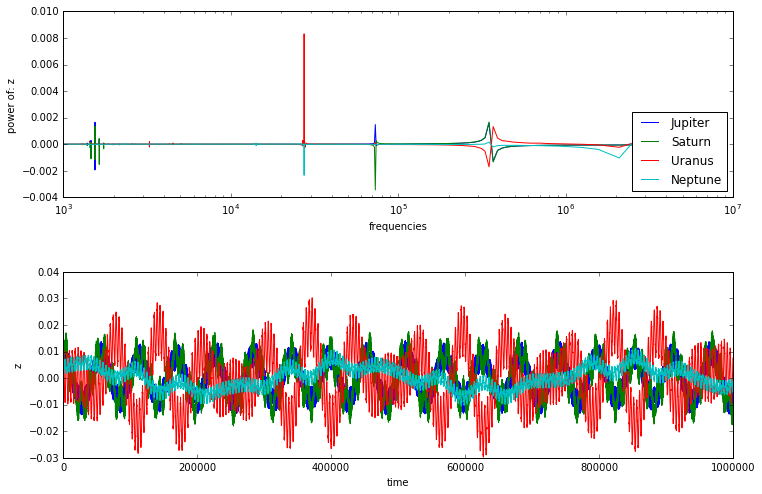

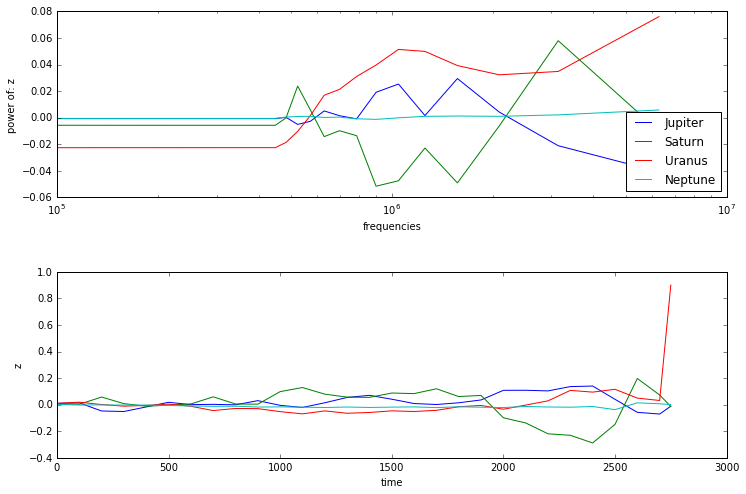

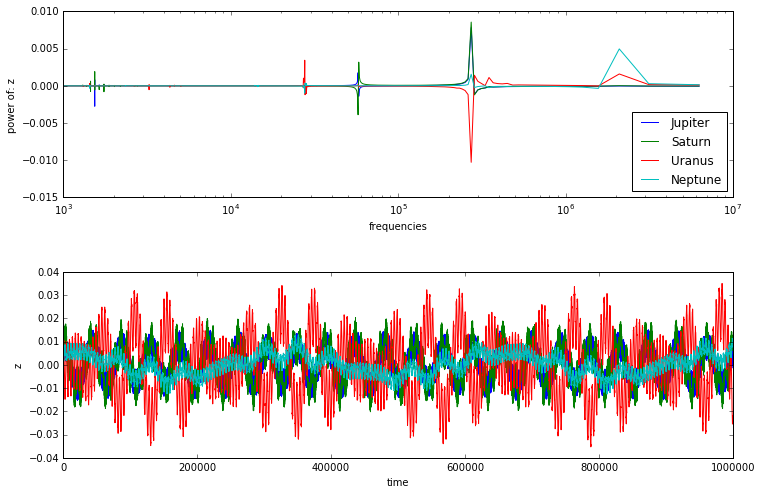

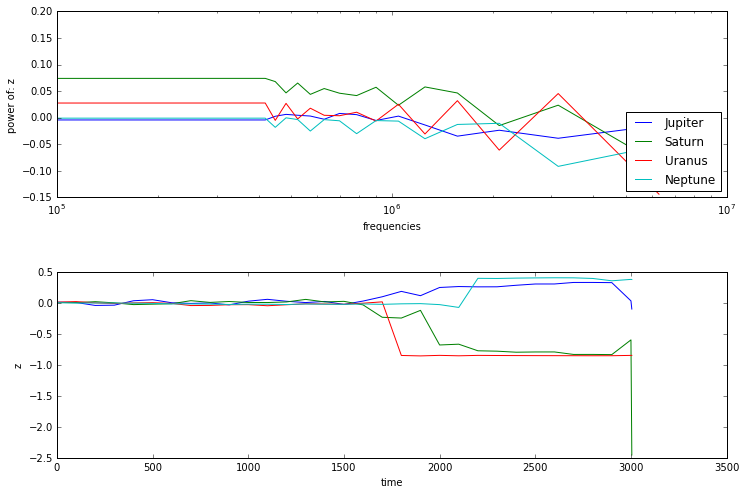

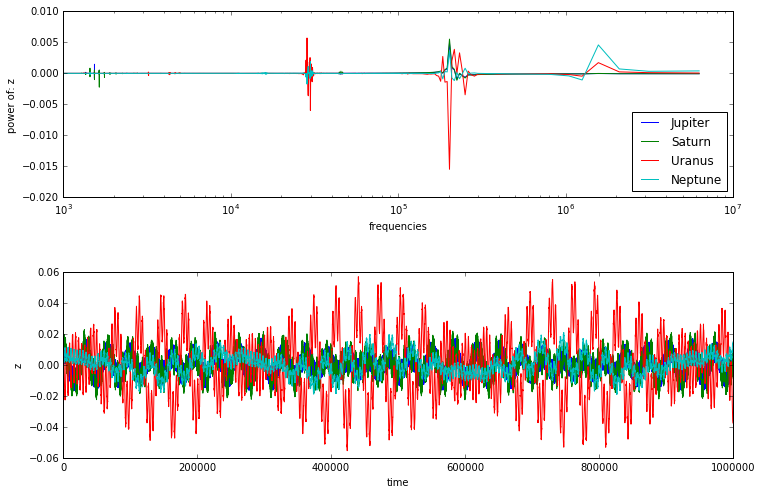

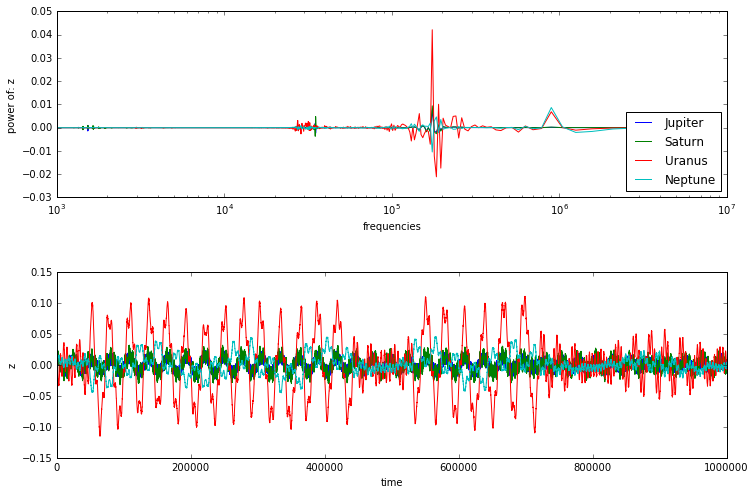

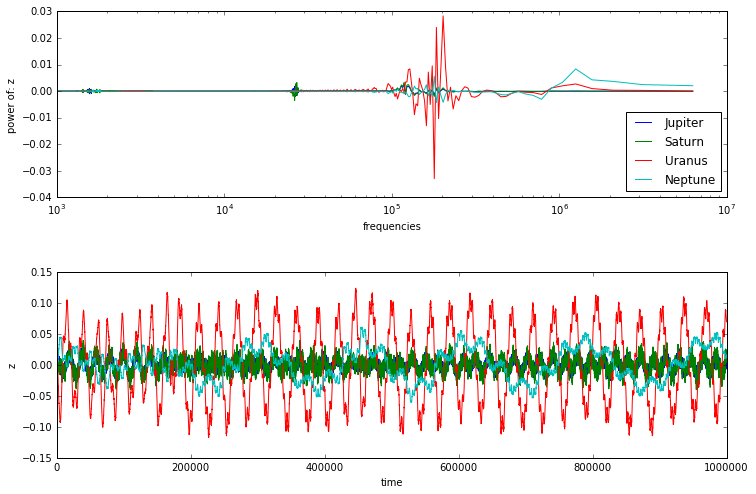

In [19]:
import glob
files = glob.glob(output_name)
columns = ['Time']
for i in ['1', '2', '3', '4']:
    columns += ['a'+i, 'P'+i, 'e'+i, 'pomega'+i, 'inc'+i, 'Omega'+i, 'f'+i]

for f in files:
    data = pd.read_csv(f,header=None,names=columns)
    tmax = float(f.split("_")[-2].split("t")[1])
    N_outputs = len(data.index)
    fourier(data,var,tmax,N_outputs,f)

# Test on basic sine function

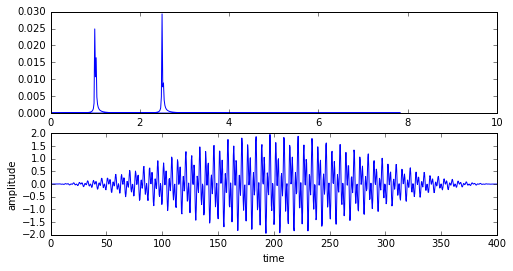

In [16]:
Npts = 1000
period = 1
min=0.
max=400.

t = np.linspace(min,max,Npts).astype('float64')
window = np.hanning(Npts)
y = (np.sin(period*t) + np.sin(2.5*period*t)).astype('float64')*window

#freq = np.linspace(0.1,10,100).astype('float64')
#power = signal.lombscargle(t,y*window,freq)
power = np.fft.fft(y)/Npts
freq = np.fft.fftfreq(Npts, max/Npts)*2*np.pi

plt.figure(figsize=(8,4))
plt.subplot(2, 1, 1)
plt.plot(freq, np.sqrt(4*power/Npts))
plt.xlim([0,10])
plt.subplot(2, 1, 2)
plt.plot(t,y)
plt.xlabel("time")
plt.ylabel("amplitude")

# Extra Code

In [ ]:
for i in ['1', '2', '3']:
    h=data["e"+i]*np.cos(data["pomega"+i])
    k=data["e"+i]*np.sin(data["pomega"+i])
    sp_h = np.fft.fft(h)
    freq_h = np.fft.fftfreq(h.shape[-1])
    sp_k = np.fft.fft(k)
    freq_k = np.fft.fftfreq(k.shape[-1])
    plt.plot(freq_h, sp_h.real)
    plt.plot(freq_k, sp_k.real)
plt.xscale('log')
plt.ylabel('h and k')
plt.xlabel('frequency')

In [ ]:
#Check that I understand what's going on
t = np.arange(250)
sp = np.fft.fft(np.sin(t))
freq = np.fft.fftfreq(t.shape[-1])
plt.plot(freq, sp.real)
plt.xlim([0.15,0.2])

In [107]:
#2-D frequency map (i.e. split data into chunks and do freq analysis of each chunk)
import scipy.signal as signal
var = "h"
n_freq = 30
n_chunks = 4

f = np.linspace(0.01, 5, n_freq)
t = data["Time"].values.reshape((n_chunks,1000/n_chunks)) #10 rows of 100 entries each
y = get_var(data,"1",var).reshape((n_chunks,1000/n_chunks))
powers = []
freq = []
index = []
for i in range(n_chunks):
    powers.append(signal.lombscargle(t[i],y[i],f))
    freq.append(f)
    index.append(np.ones(n_freq)*i*0.1)

index = np.asarray(index)
powers = np.asarray(powers)
freq = np.asarray(freq)

#plot
im = plt.scatter(freq,index,c=powers,cmap='coolwarm',lw=0,s=20);
plt.colorbar(im, label='power')
plt.xlabel("frequency")
plt.ylabel("time chunk (arbitrary scaling)")

ValueError: total size of new array must be unchanged

So what I want to do is do a fourier transform (or maybe lomb scargle) of each orbital element (and other elements like h and k) and see if the frequency contributions change with time. The FFT takes as input the samples at evenly spaced intervals, the lomb-scargle doesn't need to be evenly spaced.